In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import random
import copy
import matplotlib.pyplot as plt

from torch.utils.data import Dataset,DataLoader,random_split

In [2]:
def gram_schmidt_orthogonalization(standard_param, target_param,eps=1e-25):
    '''
    date: 2021.10.21 -> standard_param, target_param type is only valid for torch 
    Method: Neural network model parameter orthogonalization using Gram-Schmidt orthogonalization process
    input    
        standard_param: torch.tensor
        target_param: torch.tensor
    output
        orthogonal_vector = After gram-schmidt process (vector, matrix whatever)
    '''
    assert isinstance(standard_param,np.ndarray) or torch.is_tensor(standard_param), \
        "Please, check standard Parameter is {numpy, torch} variable"
    assert isinstance(target_param,np.ndarray) or torch.is_tensor(target_param), \
        "Please, check target Parameter is {numpy, torch} variable"
    
    # matrix --> reshape?
    origin_size = target_param.size()
    standard_param = standard_param.view(-1,)
    target_param = target_param.view(-1,)
    
    # gram-schmidt orthogonalization and original shapre restoring
    proj_t_on_s = torch.dot(standard_param,target_param)/(torch.dot(standard_param,standard_param)+eps)*standard_param
    orthogonal_vec = target_param-proj_t_on_s
    orthogonal_vec = orthogonal_vec.view([sz for sz in origin_size])
    # matrix --> SVD???? later.....
    return orthogonal_vec

### Making sinusoid test list

In [3]:
x = np.linspace(-3,3,10000)
amp = np.random.uniform(0.1,5,10000)
phi = np.random.uniform(0,np.pi,10000)

num_task = 100
data_list = []
for nt in range(num_task):
    y = amp[nt]*np.sin(x+phi[nt])
    data = np.stack((x,y),axis=1)
    data_list.append(data)
data_list = np.array(data_list)

In [4]:
print(data_list[0].shape)

(10000, 2)


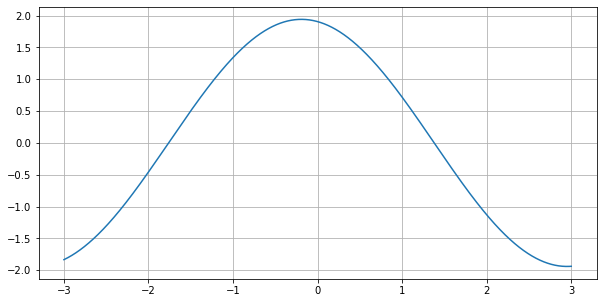

In [5]:
# plotting
data = data_list[0]
x,y = data[:,0], data[:,1]
plt.figure(figsize=(10,5))
plt.plot(x,y)
plt.grid()

In [38]:
device = torch.device('cuda:0')
print(device)
#device = torch.device('cpu')

cuda:0


In [39]:
class Basic_model(nn.Module):
    def __init__(self,num_hidden_layer=3,num_hidden_node=32,input_dim=1,output_dim=1):
        super(Basic_model,self).__init__()
        self.linears = nn.ModuleList([nn.Linear(input_dim,num_hidden_node)])
        self.linears.extend([nn.Linear(num_hidden_node,num_hidden_node) for i in range(num_hidden_layer-1)])
        self.linears.append(nn.Linear(num_hidden_node,output_dim))
        
    def forward(self,x):
        for idx, branch in enumerate(self.linears):
            if idx != len(self.linears)-1:
                x = F.elu(branch(x))
            else:
                x = branch(x)
        return x

In [40]:
class SINUSOID_dataset(Dataset):
    def __init__(self,data):
        self.x, self.y = data[:,0],data[:,1]
        self.x = self.x.reshape(-1,1)
        self.y = self.y.reshape(-1,1)
        
    def __getitem__(self,idx):
        return torch.FloatTensor(self.x[idx,:]), torch.FloatTensor(self.y[idx,:])
    
    def __len__(self):
        return len(self.x)

In [41]:
epochs = 1000
batch_size=128
learning_rate = 0.01
scheduler_step_number=25
scheduler_gamma=0.97

In [42]:
data = data_list[0]# 
criterion = nn.MSELoss()
backup_data = copy.deepcopy(data)
np.random.shuffle(data)
train_data = data[:int(len(data)*0.8)]
valid_data = data[int(len(data)*0.8):]

train_set = SINUSOID_dataset(train_data)
valid_set = SINUSOID_dataset(valid_data)
train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True,drop_last=False)
valid_loader = DataLoader(valid_set,batch_size=batch_size,shuffle=False,drop_last=False)

model = Basic_model().to(device)
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=(epochs//scheduler_step_number),gamma=scheduler_gamma)

best_valid = np.inf
for e in range(epochs):
    train_loss = 0
    model.train()
    for x,y in train_loader:
        x = x.to(device)
        y = y.to(device)
        
        pred = model(x)
        loss = criterion(pred,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_loss /= len(train_loader)
    
    valid_loss = 0
    model.eval()
    for x,y in valid_loader:
        x = x.to(device)
        y = y.to(device)
        x.requires_grad=True
        
        pred = model(x)
        loss = criterion(pred,y)
        valid_loss += loss.item()
    valid_loss /= len(valid_loader)
    
    if valid_loss < best_valid:
        best_valid = valid_loss
        best_model = copy.deepcopy(model)
    
    if e % 100 == 0:
        print(f'Epochs: {e}, training loss: {train_loss}, validation loss: {valid_loss}, best_valid_loss: {best_valid}')

# score printing
torch.save(best_model,'./best_model.pth')

Epochs: 0, training loss: 0.2306773373931055, validation loss: 0.008287836681120098, best_valid_loss: 0.008287836681120098
Epochs: 100, training loss: 0.00035898272232323447, validation loss: 6.819023883508635e-05, best_valid_loss: 1.196731591335265e-05
Epochs: 200, training loss: 0.0002186294235769541, validation loss: 0.0003432515022723237, best_valid_loss: 8.09611165664137e-06
Epochs: 300, training loss: 3.190585281002328e-05, validation loss: 3.147629024624621e-05, best_valid_loss: 8.09611165664137e-06
Epochs: 400, training loss: 3.802254146677793e-05, validation loss: 4.606280913321825e-05, best_valid_loss: 6.4725508934770914e-06
Epochs: 500, training loss: 9.721805633042037e-05, validation loss: 5.348861395759741e-05, best_valid_loss: 6.4725508934770914e-06
Epochs: 600, training loss: 4.7189647317743886e-05, validation loss: 2.1249129190437088e-05, best_valid_loss: 6.4725508934770914e-06
Epochs: 700, training loss: 1.7700005238501554e-05, validation loss: 1.479252949820875e-05, b

(10000, 1)


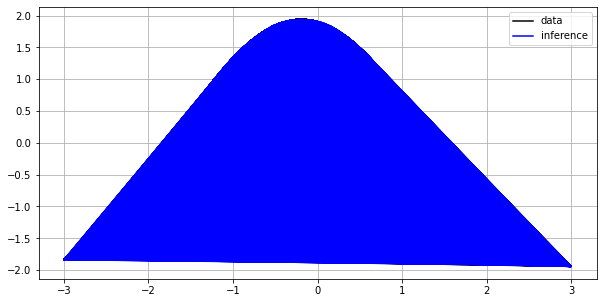

In [43]:
x,y = backup_data[:,0],backup_data[:,1]

input_x = torch.Tensor(x).to(device).view(-1,1)
output_y = best_model(input_x).detach().cpu().numpy()
print(output_y.shape)
plt.figure(figsize=(10,5))
plt.plot(x,y,'k-',label='data')
plt.plot(x,output_y,'b-',label='inference')
plt.grid()
plt.legend()

In [44]:
print('done')

done


In [45]:
def fisher_information_value(model, criterion, data_loader):
    precision_matrices = {}
    for n,p in model.named_parameters():
        precision_matrices[n] = 0
    
    model.eval()
    for x,y in data_loader:
        model.zero_grad()
        x = x.to(device)
        y = y.to(device)
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        
        for n,p in model.named_parameters():
            precision_matrices[n] += p.grad.data**2
    precision_matrices = {n:p for n,p in precision_matrices.items()}
    return precision_matrices

fisher_matrix = fisher_information_value(best_model,criterion,valid_loader)
#print(fisher_matrix)
best_max = 0
best_min = np.inf
for key,value in fisher_matrix.items():
    print(key, value.sum())
    if value.sum().detach().cpu().numpy() > best_max:
        best_max = value.sum().detach().cpu().numpy()
        best_max_name = key
    if value.sum().detach().cpu().numpy() < best_min:
        best_min = value.sum().detach().cpu().numpy()
        best_min_name = key
        
print('-------------------------------')
print('Max_Key:', best_max_name)
print('Max_Value:',best_max)
print('Min_Key:', best_min_name)
print('Min_Value:',best_min)

linears.0.weight tensor(3.0746e-05, device='cuda:0')
linears.0.bias tensor(7.9053e-06, device='cuda:0')
linears.1.weight tensor(1.3146e-05, device='cuda:0')
linears.1.bias tensor(1.2233e-06, device='cuda:0')
linears.2.weight tensor(4.1553e-05, device='cuda:0')
linears.2.bias tensor(1.6752e-06, device='cuda:0')
linears.3.weight tensor(0.0008, device='cuda:0')
linears.3.bias tensor(1.0799e-05, device='cuda:0')
-------------------------------
Max_Key: linears.3.weight
Max_Value: 0.00076972356
Min_Key: linears.1.bias
Min_Value: 1.2232556e-06


### Transfer learning dataset preparation

In [46]:
data = data_list[2]# 
backup_data = copy.deepcopy(data)
np.random.shuffle(data)
train_data = data[:int(len(data)*0.8)]
valid_data = data[int(len(data)*0.8):]

train_set = SINUSOID_dataset(train_data)
valid_set = SINUSOID_dataset(valid_data)
train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True,drop_last=False)
valid_loader = DataLoader(valid_set,batch_size=batch_size,shuffle=False,drop_last=False)

### normal transfer learning

In [47]:
criterion = nn.MSELoss()

#model = Basic_model().to(device)
model = torch.load('./best_model.pth')
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=(epochs//scheduler_step_number),gamma=scheduler_gamma)

best_valid = np.inf
for e in range(epochs):
    train_loss = 0
    model.train()
    for x,y in train_loader:
        x = x.to(device)
        y = y.to(device)
        
        pred = model(x)
        loss = criterion(pred,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_loss /= len(train_loader)
    
    valid_loss = 0
    model.eval()
    for x,y in valid_loader:
        x = x.to(device)
        y = y.to(device)
        x.requires_grad=True
        
        pred = model(x)
        loss = criterion(pred,y)
        valid_loss += loss.item()
    valid_loss /= len(valid_loader)
    
    if valid_loss < best_valid:
        best_valid = valid_loss
        best_model = copy.deepcopy(model)
    
    if e % 100 == 0:
        print(f'Epochs: {e}, training loss: {train_loss}, validation loss: {valid_loss}, best_valid_loss: {best_valid}')

# score printing      
#torch.save(best_model,'./best_model.pth')

Epochs: 0, training loss: 0.11903080819470305, validation loss: 0.002465557925461326, best_valid_loss: 0.002465557925461326
Epochs: 100, training loss: 3.995465247874289e-05, validation loss: 2.2133151901471138e-05, best_valid_loss: 2.0489837083914608e-05
Epochs: 200, training loss: 8.411102008101315e-05, validation loss: 5.469431062010699e-05, best_valid_loss: 1.9610777371781296e-05
Epochs: 300, training loss: 6.337895507703439e-05, validation loss: 0.00012835680990974652, best_valid_loss: 1.17280764015959e-05
Epochs: 400, training loss: 7.477500057864254e-05, validation loss: 6.359332110150717e-05, best_valid_loss: 1.17280764015959e-05
Epochs: 500, training loss: 0.00010995649730224007, validation loss: 4.387258809401828e-05, best_valid_loss: 1.17280764015959e-05
Epochs: 600, training loss: 9.74576093237071e-05, validation loss: 0.00018482674022379797, best_valid_loss: 1.17280764015959e-05
Epochs: 700, training loss: 7.282917186020068e-05, validation loss: 2.4956583729363047e-05, bes

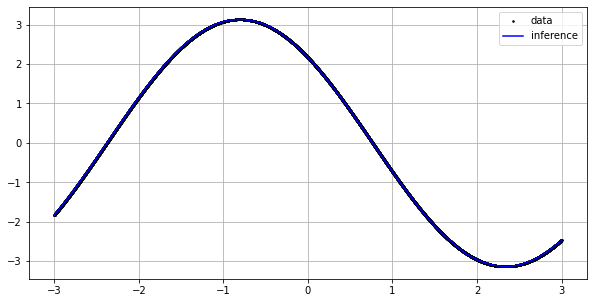

In [48]:
plt.figure(figsize=(10,5))
x,y = backup_data[:,0],backup_data[:,1]
plt.plot(x,y,'ko',label='data',markersize=1.5)
x = np.sort(x)
input_x = torch.Tensor(x).to(device).view(-1,1)
output_y = best_model(input_x).detach().cpu().numpy()
plt.plot(x,output_y,'b-',label='inference')
plt.grid()
plt.legend()

### Fisher information - Gram_Schimidt orthogonalization

In [49]:
data = data_list[2]# 
criterion = nn.MSELoss()
backup_data = copy.deepcopy(backup_data)

np.random.shuffle(data)
train_data = data[:int(len(data)*0.8)]
valid_data = data[int(len(data)*0.8):]

train_set = SINUSOID_dataset(train_data)
valid_set = SINUSOID_dataset(valid_data)
train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True,drop_last=False)
valid_loader = DataLoader(valid_set,batch_size=batch_size,shuffle=False,drop_last=False)

#model = Basic_model().to(device)
model = torch.load('./best_model.pth')
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=(epochs//scheduler_step_number),gamma=scheduler_gamma)

fisher_matrix = fisher_information_value(model,criterion,train_loader)
#print(fisher_matrix)
best_max = 0
best_min = np.inf
for key,value in fisher_matrix.items():
    print(key, value.sum())
    if value.sum().detach().cpu().numpy() > best_max:
        best_max = value.sum().detach().cpu().numpy()
        best_max_name = key
    if value.sum().detach().cpu().numpy() < best_min:
        best_min = value.sum().detach().cpu().numpy()
        best_min_name = key
        
print('-------------------------------')
print('Max_Key:', best_max_name)
print('Max_Value:',best_max)
print('Min_Key:', best_min_name)
print('Min_Value:',best_min)

for name,parameter in model.named_parameters():
    best_layer = best_max_name.split('.')[1]
    layer_number = name.split('.')[1]
    #if layer_number != best_layer:
    if layer_number == best_min_name.split('.')[1]:
        parameter.data.copy_(gram_schmidt_orthogonalization(parameter,torch.randn(parameter.size())\
                                                            .to(parameter.device)))

best_valid = np.inf
for e in range(epochs):
    train_loss = 0
    model.train()
    for x,y in train_loader:
        x = x.to(device)
        y = y.to(device)
        
        pred = model(x)
        loss = criterion(pred,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_loss /= len(train_loader)
    
    valid_loss = 0
    model.eval()
    for x,y in valid_loader:
        x = x.to(device)
        y = y.to(device)
        x.requires_grad=True
        
        pred = model(x)
        loss = criterion(pred,y)
        valid_loss += loss.item()
    valid_loss /= len(valid_loader)
    
    if valid_loss < best_valid:
        best_valid = valid_loss
        best_model = copy.deepcopy(model)
    
    if e % 100 == 0:
        print(f'Epochs: {e}, training loss: {train_loss}, validation loss: {valid_loss}, best_valid_loss: {best_valid}')

# score printing      
#torch.save(best_model,'./best_model.pth')

linears.0.weight tensor(356.3076, device='cuda:0')
linears.0.bias tensor(191.2274, device='cuda:0')
linears.1.weight tensor(165.6955, device='cuda:0')
linears.1.bias tensor(14.5939, device='cuda:0')
linears.2.weight tensor(241.5309, device='cuda:0')
linears.2.bias tensor(2.8956, device='cuda:0')
linears.3.weight tensor(1897.8557, device='cuda:0')
linears.3.bias tensor(4.0739, device='cuda:0')
-------------------------------
Max_Key: linears.3.weight
Max_Value: 1897.8557
Min_Key: linears.2.bias
Min_Value: 2.895595
Epochs: 0, training loss: 0.231824596612049, validation loss: 0.002708273932512384, best_valid_loss: 0.002708273932512384
Epochs: 100, training loss: 6.42927108625401e-05, validation loss: 4.472120440368599e-05, best_valid_loss: 1.641647781980282e-05
Epochs: 200, training loss: 0.0005036229630359375, validation loss: 0.00011450792544565047, best_valid_loss: 1.641647781980282e-05
Epochs: 300, training loss: 0.00043125718828320266, validation loss: 0.0010848932106455322, best_va

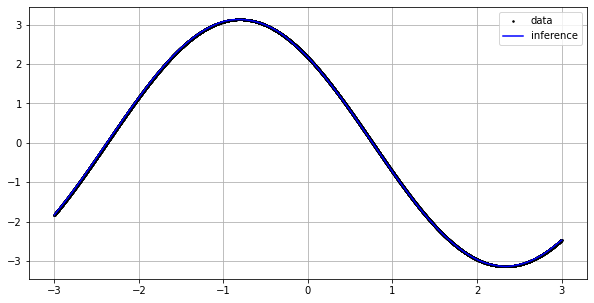

In [50]:
plt.figure(figsize=(10,5))
x,y = backup_data[:,0],backup_data[:,1]
plt.plot(x,y,'ko',label='data',markersize=1.5)
x = np.sort(x)
input_x = torch.Tensor(x).to(device).view(-1,1)
output_y = best_model(input_x).detach().cpu().numpy()
plt.plot(x,output_y,'b-',label='inference')
plt.grid()
plt.legend()

### Now, Let's test for limited data size transfer learning? > 50%

In [ ]:
data = data_list[5]# 
backup_data = copy.deepcopy(data)
np.random.shuffle(data)
train_data = data[:int(len(data)*0.5)]
valid_data = data[int(len(data)*0.5):]

train_set = SINUSOID_dataset(train_data)
valid_set = SINUSOID_dataset(valid_data)
train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True,drop_last=False)
valid_loader = DataLoader(valid_set,batch_size=batch_size,shuffle=False,drop_last=False)

### Normal transfer learning

In [ ]:
criterion = nn.MSELoss()

#model = Basic_model().to(device)
model = torch.load('./best_model.pth')
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=(epochs//scheduler_step_number),gamma=scheduler_gamma)

best_valid = np.inf
for e in range(epochs):
    train_loss = 0
    model.train()
    for x,y in train_loader:
        x = x.to(device)
        y = y.to(device)
        
        pred = model(x)
        loss = criterion(pred,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_loss /= len(train_loader)
    
    valid_loss = 0
    model.eval()
    for x,y in valid_loader:
        x = x.to(device)
        y = y.to(device)
        x.requires_grad=True
        
        pred = model(x)
        loss = criterion(pred,y)
        valid_loss += loss.item()
    valid_loss /= len(valid_loader)
    
    if valid_loss < best_valid:
        best_valid = valid_loss
        best_model = copy.deepcopy(model)
    
    if e % 100 == 0:
        print(f'Epochs: {e}, training loss: {train_loss}, validation loss: {valid_loss}, best_valid_loss: {best_valid}')

In [ ]:
plt.figure(figsize=(10,5))
x,y = backup_data[:,0],backup_data[:,1]
plt.plot(x,y,'ko',label='data',markersize=1.5)
x = np.sort(x)
input_x = torch.Tensor(x).to(device).view(-1,1)
output_y = best_model(input_x).detach().cpu().numpy()
plt.plot(x,output_y,'b-',label='inference')
plt.grid()
plt.legend()

### GS transfer learning

In [ ]:
criterion = nn.MSELoss()

#model = Basic_model().to(device)
model = torch.load('./best_model.pth')
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=(epochs//scheduler_step_number),gamma=scheduler_gamma)

fisher_matrix = fisher_information_value(model,criterion,train_loader)
#print(fisher_matrix)
best_max = 0
best_min = np.inf
for key,value in fisher_matrix.items():
    print(key, value.sum())
    if value.sum().detach().cpu().numpy() > best_max:
        best_max = value.sum().detach().cpu().numpy()
        best_max_name = key
    if value.sum().detach().cpu().numpy() < best_min:
        best_min = value.sum().detach().cpu().numpy()
        best_min_name = key
        
print('-------------------------------')
print('Max_Key:', best_max_name)
print('Max_Value:',best_max)
print('Min_Key:', best_min_name)
print('Min_Value:',best_min)

for name,parameter in model.named_parameters():
    best_layer = best_max_name.split('.')[1]
    layer_number = name.split('.')[1]
    #if layer_number != best_layer:
    if layer_number == best_min_name.split('.')[1]:
        parameter.data.copy_(gram_schmidt_orthogonalization(parameter,torch.randn(parameter.size())\
                                                            .to(parameter.device)))

best_valid = np.inf
for e in range(epochs):
    train_loss = 0
    model.train()
    for x,y in train_loader:
        x = x.to(device)
        y = y.to(device)
        
        pred = model(x)
        loss = criterion(pred,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_loss /= len(train_loader)
    
    valid_loss = 0
    model.eval()
    for x,y in valid_loader:
        x = x.to(device)
        y = y.to(device)
        x.requires_grad=True
        
        pred = model(x)
        loss = criterion(pred,y)
        valid_loss += loss.item()
    valid_loss /= len(valid_loader)
    
    if valid_loss < best_valid:
        best_valid = valid_loss
        best_model = copy.deepcopy(model)
    
    if e % 100 == 0:
        print(f'Epochs: {e}, training loss: {train_loss}, validation loss: {valid_loss}, best_valid_loss: {best_valid}')

In [ ]:
plt.figure(figsize=(10,5))
x,y = backup_data[:,0],backup_data[:,1]
plt.plot(x,y,'ko',label='data',markersize=1.5)
x = np.sort(x)
input_x = torch.Tensor(x).to(device).view(-1,1)
output_y = best_model(input_x).detach().cpu().numpy()
plt.plot(x,output_y,'b-',label='inference')
plt.grid()
plt.legend()